<h5 style="color: orange; font-weight: bold;">Story:</h5>


Das Spieleunternehmen `Beam Team Publishing` hat mich damit beauftragt, die Steam-Bewertungen ihres Spiels `„Stranded Deep“` genauer zu analysieren. In letzter Zeit häufen sich die negativen Bewertungen, was dazu geführt hat, dass die Gesamtbewertung von `„Positiv“` auf `„Gemischt“` gesunken ist. Diese Veränderung wirkt sich negativ auf potenzielle Käufer aus und führt bereits zu einem Rückgang bei den Verkäufen sowie zu vermehrten Rückgaben des Spiels.

Um diesen Trend aufzuhalten, soll ich mithilfe einer Klassifizierungsanalyse herausfinden, welche Merkmale in den Reviews eher auf eine negative Bewertung hindeuten. Das Ziel ist es, ein Modell zu entwickeln, das in der Lage ist, Bewertungen als positiv oder negativ zu klassifizieren. Dieses Modell wird das Team in Zukunft unterstützen, negative Rückmeldungen in Echtzeit zu identifizieren und schneller auf Kritikpunkte oder Bugs einzugehen. Das Modell soll auf ihrem Discord-Server eingesetzt werden, wo sie in Echtzeit unannotierte Bewertungen von Spielern erhalten.

Durch die gezielte Analyse und Bearbeitung der negativen Bewertungen kann das Unternehmen die Gesamtbewertung auf Steam langfristig wieder ins Positive lenken, die Verkaufszahlen steigern und die Zufriedenheit der Spieler erhöhen.

<h5 style="color: orange; font-weight: bold;">The Data:</h5>


In [ ]:
#Importe
import re
import nltk
import joblib
import pandas as pd
import seaborn as sns
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer, roc_curve, auc

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Elvan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elvan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elvan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Elvan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elvan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Daten Einlesen
df = pd.DataFrame()
df = pd.read_csv('steam_reviews.csv')

Tabellarische Darstellung der Features des Datensatzes:

| Attribut | Erläuterung | 
| :----: | :---: | 
|   Title    |   Recommended & Not Recommended (TARGET)   | 
|   Date Posted    |   Tag an dem die Bewertung gepostet wurde   | 
|   Hours Played    |   Spielstunden insgesamt   | 
|   Review    |   Bewertungstext des Spiels   | 

In [4]:
df.tail(5)

,Title,Date Posted,Hours Played,Review
21055,Recommended,"Posted: July 6, 2015",29.8 hrs on record,This game is absolutely wonderfull and incredi...
21056,Recommended,"Posted: July 5, 2015",23.6 hrs on record,This is a really good game you can enjoy for h...
21057,Recommended,"Posted: July 5, 2015",42.4 hrs on record,this game is pretty cool but theres not enough...
21058,Not Recommended,"Posted: July 4, 2015",8.9 hrs on record,"I bought this game in the steam summer sale, a..."
21059,Recommended,"Posted: July 4, 2015",26.5 hrs on record,I bought this game about four years ago. Back ...


**Erste Auffälligkeiten:**
- Das `Title` Attribut werde ich in `Target` umbenennen im Preprocessing-Schritt.
- `Recommended` und `Not Recommended` werde ich als 0 und 1 mappen. 
- `Hours Played` kann als String nicht analysiert werden. Ich werde den Text in der Spalte also entfernen und ein Float Attribut daraus machen. 
- `Date Posted` enthält ebenfalls Text, was bereinigt werden muss. Diese Spalte wird jedoch nicht weiter benötigt für die Analyse und wird deshalb im Preprocessing-Schritt gelöscht.

<h5 style="color: orange; font-weight: bold;">IDA - Initial Data Analysis:</h5>

In [5]:
print(f'Der vorhandene Datensatz beschreibt {df.shape[0]} Reviews aus Steam mit {df.shape[1]} unterschiedlichen Features.')

Der vorhandene Datensatz beschreibt 21060 Reviews aus Steam mit 4 unterschiedlichen Features.


In [6]:
# Datentypen ansehen
df.dtypes

Title           object
Date Posted     object
Hours Played    object
Review          object
dtype: object

Momentan bestehen alle Attribute aus Strings und werden dementsprechend als Objekte angesehen. Für eine Analyse sollten die textuellen Features in nummerische Werte transformiert werden, um sie in Modellen verwenden zu können. 

Das Attribut Hours Played wird nach Bereinigungin einen Float-Wert konvertiert, Title in einen Integer, Review wird durch Text-Mining-Methoden in eine maschinenlesbare Form überführt und Date Posted gelöscht. 

In [7]:
# Überprüfung auf Dubletten
duplicate_rows_count = df.duplicated().sum()
print(f"Anzahl an Dubletten im DataFrame: {duplicate_rows_count}")

Anzahl an Dubletten im DataFrame: 0


Es scheint keine doppelten Reviews zu geben, was gut ist da hier nicht weiter gemacht werden muss.

In [8]:
# Überprüfung auf fehlende Werte
missing_values_count = df.isna().sum()  # Zählt NaN-Werte in jeder Spalte
empty_values_count = (df == '').sum()   # Zählt leere Strings in jeder Spalte

# Ausgabe der Anzahl fehlender und leerer Werte je Spalte
for column in df.columns:
    print(f"Anzahl der fehlenden Werte (NaN) in der '{column}'-Spalte: {missing_values_count[column]}")
    print(f"Anzahl der leeren Werte in der '{column}'-Spalte: {empty_values_count[column]}")

Anzahl der fehlenden Werte (NaN) in der 'Title'-Spalte: 0
Anzahl der leeren Werte in der 'Title'-Spalte: 0
Anzahl der fehlenden Werte (NaN) in der 'Date Posted'-Spalte: 0
Anzahl der leeren Werte in der 'Date Posted'-Spalte: 0
Anzahl der fehlenden Werte (NaN) in der 'Hours Played'-Spalte: 0
Anzahl der leeren Werte in der 'Hours Played'-Spalte: 0
Anzahl der fehlenden Werte (NaN) in der 'Review'-Spalte: 0
Anzahl der leeren Werte in der 'Review'-Spalte: 0


Der Datensatz besitzt keine fehlenden Werte.

In [9]:
# Formatierte Ausgabe der ersten 3 Review-Texte
for i, review in enumerate(df['Review'].head(3), start=1):
    print(f"Review {i}: {review}")

Review 1: I feel, as the game stands, there isn't enough danger. I am fully aware that it is early days, but i'm also aware they're open to suggestions. I recommend the game as it stands, if you are happy funding development for a game that has SO MUCH potential, and a few solid hours of enjoyment in it's current state.

Things i'd personally like to see:

-Less sharks (they should be terrifying when encountered, dangerous depending on the species, and you shouldn't be able to swim as fast as them and kill them with your pocket knife. Get rid of that stupid music too, a shark attack should be unexpected, this isn't Jaws.)
-You should be able to break your raft if you hit it with a sharp object... if you're stupid enough to attack your boat, you deserve to die.
-More island variations: It feels that every island is 'roughly' the same size, and they're all spread out at equal distances... perhaps a few islands linked together, maybe a big island with cliffs (give an element to exploring 

Die erste Bewertung ist sehr lang und enthält zahlreiche Aufzählungs- und Sonderzeichen, die bei der Klassifizierung stören könnten. Da klassische Modelle rein auf Häufigkeitsinformationen basieren, können sie die Semantik dieser Zeichen nicht erfassen. Solche Sonderzeichen können zudem störend wirken, indem sie das Modell unnötig verkomplizieren oder „Rauschen“ in die Daten einbringen. Deshalb habe ich mich entschieden, die Sonderzeichen im Preprocessing-Schritt zu entfernen, da sie die Klassifizierung nicht verbessern.

In [10]:
# Alle Nicht-ASCII-Zeichen extrahieren und sammeln
non_ascii_chars = set()

for text in df['Review']:
    non_ascii_chars.update(re.findall(r'[^\x00-\x7F]', text))

print("Gefundene Nicht-ASCII-Zeichen:", non_ascii_chars)

Gefundene Nicht-ASCII-Zeichen: {'的', '̹', '⣆', '😒', '化', '⡞', '⠕', '⢘', '鸡', '⣫', '⢑', 'Ö', 'ề', 'ζ', '申', '̚', '͘', '⡽', '̸', 'Д', 'Е', '̍', '意', 'ν', '⠯', 'đ', '—', '̌', '━', '⣯', '⣄', '̶', '⡃', '相', '⠘', '规', '✿', '脱', '￣', '间', '̋', 'Я', '͗', '机', '⊐', 'κ', '⣋', 'ợ', '🏻', '𐄂', '̒', '✗', 'ш', '–', '⣹', 'เ', 'อ', '̮', '⠝', 'á', '̼', '͆', 'ᴜ', '哪', 'ế', '•', '物', '⣭', '가', '⢞', '出', '⊏', '候', '⢗', 'ก', '█', '🤣', '⡳', '其', '👱', '업', '拿', '𝟸', '场', '̴', '₂', '⢕', 'É', '❐', '潮', 'ل', '⠈', '⡕', '̥', '︎', '跟', 'ᴘ', '虽', '屿', '¼', '⚪', 'إ', '⣲', '͓', '❤', 'ᴀ', 'ى', '你', '能', '₀', '😀', '⡲', 'า', '⠻', '⢣', '👍', '★', '…', '⣔', '☺', '⡈', '挺', '已', '語', '汐', '͊', '🤪', '😄', '⣜', '⠸', '⣂', '为', '®', '⣒', '系', '汉', '\u202a', '，', 'ヮ', 'Т', 'ʏ', '集', '马', '◠', '⣵', '在', 'ص', '⣶', '륙', 'σ', '◄', '🟦', '⡤', '么', '⢳', '有', 'ร', '（', 'ต', '⠙', '⡠', 'ه', 'ɢ', 'Ü', 'å', '⠰', '͑', '好', '│', 'μ', '⠟', '次', 'н', '◉', 'б', '⣏', 'о', '☞', 'К', 'М', '什', '̕', '̭', 'ó', '⡧', '⣣', 'ό', '⣤', '🏎', '尸', '⡂', 'в', 'і'

In den Texten gibt es einige Symbole, die für die Klassifizierungsaufgabe keinen Mehrwert bieten. Da klassische Klassifizierungsalgorithmen wie Naive Bayes oder Logistic Regression spezielle Symbole oder Emojis nicht interpretieren können und ausschließlich mit numerischen Merkmalen arbeiten, werden diese Symbole im Preprocessing-Schritt aus den Texten entfernt.

In [11]:
# Zählt das Vorkommen von URLs, HTML-Tags im gesamten Datensatz
url_count = df['Review'].apply(lambda x: bool(re.search(r'http\S+|www.\S+', x))).sum()
html_count = df['Review'].apply(lambda x: bool(re.search(r'<.*?>', x))).sum()
newline_count = df['Review'].str.count('\n').sum()

print(f"Anzahl der Reviews mit URLs: {url_count}")
print(f"Anzahl der Reviews mit HTML-Tags: {html_count}")
print(f"Gesamtanzahl der \\n-Zeichen im Datensatz: {newline_count}")

Anzahl der Reviews mit URLs: 36
Anzahl der Reviews mit HTML-Tags: 7
Gesamtanzahl der \n-Zeichen im Datensatz: 36330


Auch diese Symbole werden im Preprocessing-Schritt entfernt, weil sie für die Klassifikation keinen Mehrwert bringen.

<h5 style="color: orange; font-weight: bold;">Preprocessing:</h5>

In [12]:
# Umbenennen der Spalte "Title" in "Target"
df = df.rename(columns={'Title': 'Target'})

In [ ]:
# Entfernen des Textes "hrs on record", der Tausendertrennzeichen (Komma) und Umwandlung in Float
df['Hours Played'] = df['Hours Played'].str.replace(' hrs on record', '', regex=False)
df['Hours Played'] = df['Hours Played'].str.replace(',', '', regex=False).astype(float)

In [14]:
# Entfernen der "Date Posted"-Spalte
df = df.drop(columns=['Date Posted'])

In [15]:
# Mapping von "Recommended" und "Not Recommended" zu 1 und 0 in Target Attribut
df['Target'] = df['Target'].map({'Recommended': 1, 'Not Recommended': 0})

In [16]:
df.head()

,Target,Hours Played,Review
0,1,84.1,"I feel, as the game stands, there isn't enough..."
1,1,12.0,we need multiplayer!!!!!!!!!!!!!!!
2,1,63.1,All this game needs is online co op
3,1,16.2,LIKE THIS SO DEVS SEE DEMAND FOR ONLINE COOP
4,1,1990.9,I really like where this game is headed. Been ...


In [17]:
df.dtypes

Target            int64
Hours Played    float64
Review           object
dtype: object

In [18]:
# Initialisieren von Lemmatizer und Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text bereinigen und normalisieren
def TextCleaner(text):
    # URLs entfernen
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # HTML-Tags entfernen
    text = re.sub(r'<.*?>', ' ', text)
    # Nicht-ASCII-Zeichen entfernen
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Sonderzeichen entfernen (nur Wörter und Leerzeichen behalten)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Zeilenumbrüche und überflüssige Leerzeichen entfernen
    text = re.sub(r'\s+', ' ', text).strip()
    # In Kleinbuchstaben umwandeln
    text = text.lower()
    
    # Tokenisieren
    tokens = word_tokenize(text)
    # Stopwords entfernen und Lemmatization anwenden
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Zusammenfügen der bereinigten Tokens
    text = ' '.join(cleaned_tokens)
    return text

In [19]:
# Neue Spalte "Review_cleaned" erstellen mit der bereinigten Version des Textes
df['Review_cleaned'] = df['Review'].apply(TextCleaner)

In [20]:
df.head()

,Target,Hours Played,Review,Review_cleaned
0,1,84.1,"I feel, as the game stands, there isn't enough...",feel game stand enough danger fully aware earl...
1,1,12.0,we need multiplayer!!!!!!!!!!!!!!!,need multiplayer
2,1,63.1,All this game needs is online co op,game need online co op
3,1,16.2,LIKE THIS SO DEVS SEE DEMAND FOR ONLINE COOP,like devs see demand online coop
4,1,1990.9,I really like where this game is headed. Been ...,really like game headed playing couple year se...


Der Text sieht jetzt deutlich sauberer aus! Als nächstes schauen wir uns den bereinigten Datensatz in der EDA näher an. 

<h5 style="color: orange; font-weight: bold;">EDA:</h5>

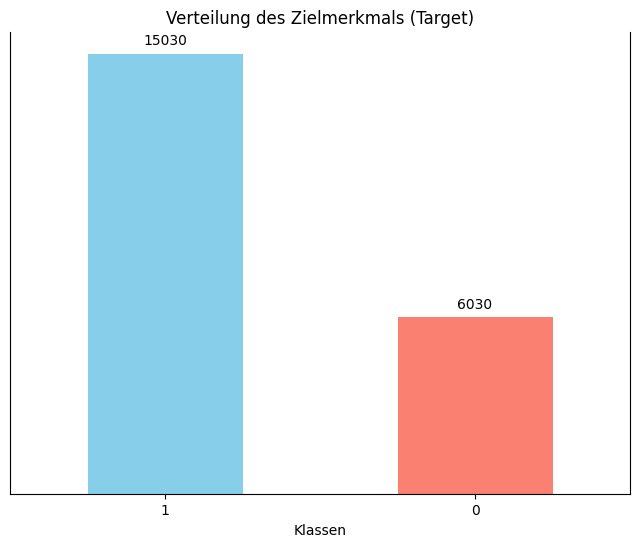

In [21]:
# Zielverteilung berechnen
target_counts = df['Target'].value_counts()

# Balkendiagramm der Zielverteilung
plt.figure(figsize=(8, 6))
bars = target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Verteilung des Zielmerkmals (Target)')
plt.xlabel('Klassen')

# Werte über Balken hinzufügen und y-Achsenbeschriftung entfernen
for index, value in enumerate(target_counts):
    plt.text(index, value + 200, f'{value}', ha='center', va='bottom')

plt.xticks(rotation=0)  # Text auf der x-Achse horizontal ausrichten
plt.gca().get_yaxis().set_visible(False)  # y-Achsenbeschriftung ausblenden

# Oberen Rahmen entfernen
plt.gca().spines['top'].set_visible(False)

plt.show()

Bei der Untersuchung der Zielvariable fällt auf, dass sie stark ungleich verteilt ist. Es gibt verschiedene Techniken, um mit diesem Ungleichgewicht in den Daten umzugehen. Die beliebtesten sind:

* **Upsampling:** Hierbei werden Kopien der unterrepräsentierten Klasse hinzugefügt, um ein Gleichgewicht herzustellen. Obwohl diese Methode effektiv das Gleichgewicht wiederherstellen kann, besteht das Risiko des Overfitting. Dies geschieht, weil das Modell dazu neigen könnte, sich zu stark auf wiederholte, identische Beispiele zu verlassen, was seine Fähigkeit, auf neuen, unbekannten Daten zu generalisieren, beeinträchtigen kann.

* **Downsampling:** Bei dieser Technik werden zufällig Datenpunkte aus der überrepräsentierten Klasse entfernt. Dies führt zu einer gleichmäßigeren Verteilung der Klassen, jedoch geht wichtige Information verloren, da potenziell nützliche Daten aus dem Trainingsprozess ausgeschlossen werden.

Ich entscheide mich für die Downsampling Variante, da Upsampling aus Kopien besteht und zu Verzerrungen der Ergebnisse führen kann. 

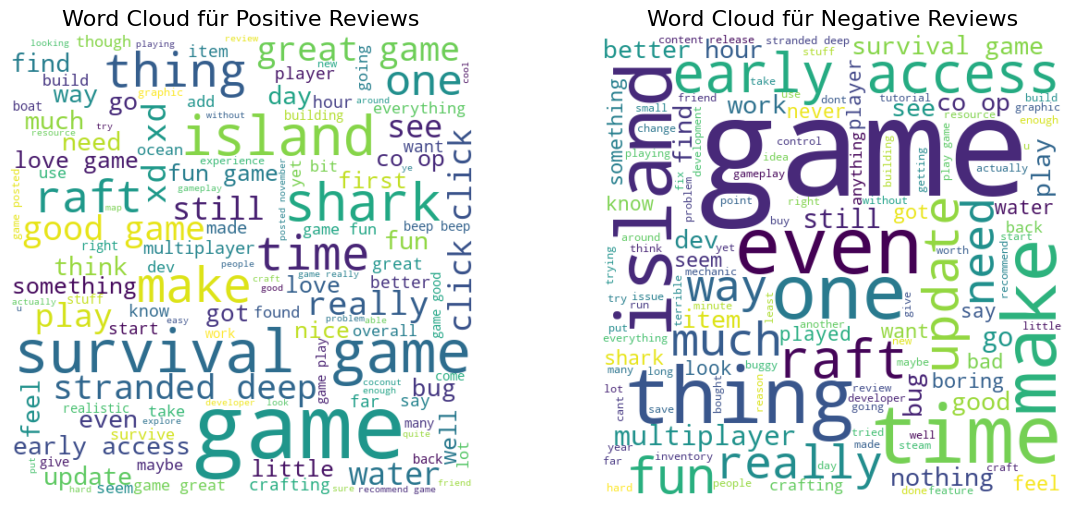

In [22]:
# Word Cloud für positive Reviews (Target = 1)
positive_reviews = df[df['Target'] == 1]['Review_cleaned'].str.cat(sep=' ')
positive_wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white').generate(positive_reviews)

# Word Cloud für negative Reviews (Target = 0)
negative_reviews = df[df['Target'] == 0]['Review_cleaned'].str.cat(sep=' ')
negative_wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white').generate(negative_reviews)

# Anzeigen der Word Clouds
plt.figure(figsize=(14, 6))

# Positive Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('Word Cloud für Positive Reviews', fontsize=16)  
plt.axis('off')

# Negative Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('Word Cloud für Negative Reviews', fontsize=16)  
plt.axis('off')

plt.show()

`Postive Reviews:`

Die Word Cloud zeigt deutlich, dass in den positiven Bewertungen hauptsächlich über die positiven Aspekte des Spiels gesprochen wird. Begriffe wie "love", "recommend game", "fun", "great", "good game" usw. werden oft verwendet. Auch wenn positive Bewertungen manchmal Kritikpunkte ansprechen, wie durch Wörter wie "bug", "problem" und "update" angedeutet wird, überwiegt das positive Feedback, was man an der Häufigkeit und Größe der positiven Begriffe erkennen kann. 

`Negative Reviews:`

Die negativen Bewertungen fokussieren sich erwartungsgemäß hauptsächlich auf Kritikpunkte. Wörter wie "bug", "boring", "potential", "issue", "hard", "lack" und "mechanic" deuten darauf hin, dass die Spieler Verbesserungen erwarten. Eines der am häufigsten verwendeten Wörter ist "make", was die Forderung nach Änderungen oder Verbesserungen unterstreicht. Wörter wie "back", "year ago", "different" und "refund" könnten darauf hindeuten, dass sich das Spiel für einige Spieler verschlechtert hat. Dies könnte auch die Änderung der Steam-Gesamtbewertung von positiv zu gemischt erklären.

Das generierte Klassifizierungsmodell könnte dem Entwicklerteam somit dabei helfen, frühzeitig auf kritische Punkte zu reagieren und damit negative Steam-Bewertungen und Rückerstattungen zu vermeiden.

#### Pearson-Korrelation:

In [23]:
# Downsampling für eine ausgeglichene Zielverteilung
positive_reviews = df[df['Target'] == 1]
negative_reviews = df[df['Target'] == 0]
positive_reviews_downsampled = positive_reviews.sample(len(negative_reviews), random_state=42)
df_balanced = pd.concat([positive_reviews_downsampled, negative_reviews])

# Berechnung der Korrelation zwischen Target und Hours Played
correlation = df_balanced['Target'].corr(df_balanced['Hours Played'])
print(f"Korrelation zwischen Target und Hours Played: {correlation:.2f}")

Korrelation zwischen Target und Hours Played: 0.14


Die Korrelation zeigt, dass der Korrelationskoeffizient zwischen den beiden Variablen `Target` und `Hours Played` bei 0.14 liegt – sowohl mit als auch ohne Downsampling.

Dieser Wert zeigt eine sehr schwache positive Korrelation zwischen den gespielten Stunden und dem Zielmerkmal. Da er nahe bei 0 liegt, deutet dies darauf hin, dass die Anzahl der gespielten Stunden kaum einen Einfluss darauf hat, ob ein Review positiv oder negativ ausfällt.

**Fazit:** Die schwache Korrelation (0.14) legt nahe, dass `Hours Played` vermutlich kein besonders aussagekräftiges Merkmal für das Klassifikationsmodell ist, wenn es darum geht, die Bewertung eines Reviews vorherzusagen. Daher wird dieses Merkmal nicht ins Klassifikationsmodell aufgenommen.

#### Durchschnittliche Wortanzahl je Target:

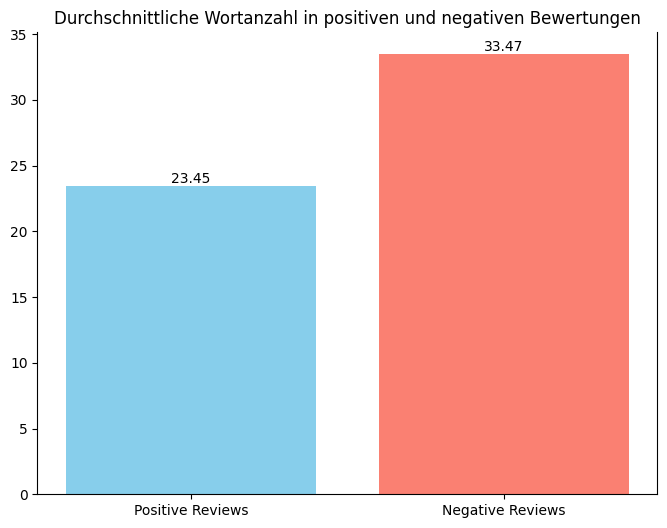

In [24]:
# Wortanzahl für jede Review berechnen 
df['word_count'] = df['Review_cleaned'].apply(lambda x: len(x.split()))

# Durchschnittliche Wortanzahl für positive und negative Bewertungen berechnen
avg_word_count_positive = df[df['Target'] == 1]['word_count'].mean()
avg_word_count_negative = df[df['Target'] == 0]['word_count'].mean()

# Balkendiagramm erstellen
plt.figure(figsize=(8, 6))
bars = plt.bar(['Positive Reviews', 'Negative Reviews'], [avg_word_count_positive, avg_word_count_negative], color=['skyblue', 'salmon'])

# Zahl über den Balken hinzufügen
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

# Titel und Achsenbeschriftungen hinzufügen
plt.title('Durchschnittliche Wortanzahl in positiven und negativen Bewertungen')
plt.ylabel(None)  # y-Achsenbeschriftung entfernen
plt.xticks(rotation=0)

# Oberen Rahmen entfernen
plt.gca().spines['top'].set_visible(False)

plt.show()

Die durchschnittliche Wortanzahl ist in negativen Bewertungen (33.47 Wörter) höher als in positiven (23.45 Wörter). Dies deutet darauf hin, dass unzufriedene Nutzer tendenziell ausführlicher ihre Kritikpunkte beschreiben, während zufriedene Nutzer oft kürzer und allgemeiner loben.

<h5 style="color: orange; font-weight: bold;">Heuristische Baseline: Vorhersage der häufigsten Klasse:</h5>

In [ ]:
# Features und Zielvariable definieren
X = df['Review_cleaned']  
y = df['Target']  

# Split: 80% Training und 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split-Größe prüfen
print('Training size:', len(X_train))
print('Test size:', len(X_test))

# Most frequent rating im Trainingsset ermitteln
most_frequent_rating = y_train.mode()[0]

# Vorhersage des häufigsten Ratings für den Test-Datensatz
y_pred_baseline = [most_frequent_rating] * len(y_test)

# Leistungsbewertung nach gewichteter F1-Score
baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')

print('Häufigste Bewertung:', most_frequent_rating)
print('Baseline Leistung (gewichteter F1-Score):', baseline_f1)

Training size: 16848
Test size: 4212
Häufigste Bewertung: 1
Baseline Leistung (gewichteter F1-Score): 0.5944327216147665


Um eine repräsentative Verteilung der Klassen in beiden Trainings- und Testsets zu gewährleisten, verwende ich eine stratifizierte Aufteilung. Dies ist besonders wichtig bei dem unausgewogenen Datensatz, da es hilft, Verzerrungen in der Modellbewertung und -training zu vermeiden und die Genauigkeit der Vorhersagen zu verbessern.

Die häufigste Bewertung liegt bei 1. Das naive Bseline-Modell, das für alle Einträge die häufigste Bewertung vorhersagt, hat auf dem Testdatensatz einen F1-Score von 0.59 erreicht. Diese Leistung dient als Ausgangsbasis für den Vergleich mit dem Klassifizierungsmodell.

<h5 style="color: orange; font-weight: bold;">Nested Cross Validation:</h5>

**Pipeline:**

In [31]:
# Cross-Validation Setup
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dummy Classifier für die Baseline
baseline_model = DummyClassifier(strategy='most_frequent')

# Nested Cross-Validation für die Dummy-Baseline
baseline_scores = cross_val_score(baseline_model, X_train, y_train, cv=outer_cv, scoring='f1_macro', n_jobs=-1)
print(f"Baseline (Most Frequent Class) - F1-Score: {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")

# Modelle und Vektorisierungsoptionen definieren
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

vectorizers = {
    'count': CountVectorizer(max_features=3000),
    'tfidf': TfidfVectorizer(max_features=3000)
}

# Nested Cross-Validation und GridSearch für jedes Modell und Vektorisierung
for model_name, model in models.items():
    for vectorizer_name, vectorizer in vectorizers.items():
        pipeline = ImbPipeline([
            ('vectorizer', vectorizer),
            ('downsample', RandomUnderSampler(random_state=42)),
            ('model', model)
        ])
        
        # Parameter-Raster für GridSearchCV
        if model_name == 'Naive Bayes':
            param_grid = {'model__alpha': [0.1, 1, 10]}
        elif model_name == 'Logistic Regression':
            param_grid = {'model__C': [0.1, 1, 10, 100]}
        elif model_name == 'Random Forest':
            param_grid = {
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [None, 10, 20, 30],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4]
            }
        else:
            param_grid = {}  # Falls keine Parameter benötigt werden

        # GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='f1_macro', n_jobs=-1)
        scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='f1_macro', n_jobs=-1)
        print(f"{model_name} mit {vectorizer_name} - F1-Score: {scores.mean():.4f} ± {scores.std():.4f}")

        # Performance-Metriken Vergleich
        metrics = ['precision_macro', 'recall_macro', 'f1_macro']
        for metric in metrics:
            grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=metric, n_jobs=-1)
            scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring=metric, n_jobs=-1)
            print(f"{metric.capitalize()} - {model_name} mit {vectorizer_name}: {scores.mean():.4f} ± {scores.std():.4f}")

        # Beste Modelle speichern
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        joblib.dump(best_model, f'best_{model_name.lower()}_{vectorizer_name}_model.joblib')

Baseline (Most Frequent Class) - F1-Score: 0.4165 ± 0.0001
Naive Bayes mit count - F1-Score: 0.7788 ± 0.0100
Precision_macro - Naive Bayes mit count: 0.7683 ± 0.0089
Recall_macro - Naive Bayes mit count: 0.8127 ± 0.0091
F1_macro - Naive Bayes mit count: 0.7788 ± 0.0100
Naive Bayes mit tfidf - F1-Score: 0.7845 ± 0.0099
Precision_macro - Naive Bayes mit tfidf: 0.7737 ± 0.0089
Recall_macro - Naive Bayes mit tfidf: 0.8193 ± 0.0090
F1_macro - Naive Bayes mit tfidf: 0.7845 ± 0.0099
Logistic Regression mit count - F1-Score: 0.8104 ± 0.0099
Precision_macro - Logistic Regression mit count: 0.8028 ± 0.0104
Recall_macro - Logistic Regression mit count: 0.8205 ± 0.0092
F1_macro - Logistic Regression mit count: 0.8104 ± 0.0099
Logistic Regression mit tfidf - F1-Score: 0.8086 ± 0.0110
Precision_macro - Logistic Regression mit tfidf: 0.7965 ± 0.0109
Recall_macro - Logistic Regression mit tfidf: 0.8311 ± 0.0103
F1_macro - Logistic Regression mit tfidf: 0.8086 ± 0.0110
Random Forest mit count - F1-Scor

### Vergleich der Modelle

| Modell                 | Metrik           | Trainingswert         | Testwert              |
|------------------------|------------------|-----------------------|-----------------------|
| **Baseline**           | F1-Score         | 0.4165 ± 0.0001       | 0.4165 ± 0.0001       |
| **Naive Bayes (count)**| Precision_macro  | 0.7683 ± 0.0089       | 0.7788 ± 0.0100       |
|                        | Recall_macro     | 0.8127 ± 0.0091       | 0.7788 ± 0.0100       |
|                        | F1_macro         | 0.7788 ± 0.0100       | 0.7788 ± 0.0100       |
| **Naive Bayes (tfidf)**| Precision_macro  | 0.7737 ± 0.0089       | 0.7845 ± 0.0099       |
|                        | Recall_macro     | 0.8193 ± 0.0090       | 0.7845 ± 0.0099       |
|                        | F1_macro         | 0.7845 ± 0.0099       | 0.7845 ± 0.0099       |
| **Logistic Regression (count)** | Precision_macro | 0.8028 ± 0.0104 | 0.8104 ± 0.0099 |
|                        | Recall_macro     | 0.8205 ± 0.0092       | 0.8104 ± 0.0099       |
|                        | F1_macro         | 0.8104 ± 0.0099       | 0.8104 ± 0.0099       |
| **Logistic Regression (tfidf)** | Precision_macro | 0.7965 ± 0.0109 | 0.8086 ± 0.0110 |
|                        | Recall_macro     | 0.8311 ± 0.0103       | 0.8086 ± 0.0110       |
|                        | F1_macro         | 0.8086 ± 0.0110       | 0.8086 ± 0.0110       |
| **Random Forest (count)** | Precision_macro | 0.7707 ± 0.0124     | 0.7780 ± 0.0110       |
|                        | Recall_macro     | 0.8076 ± 0.0095       | 0.7780 ± 0.0110       |
|                        | F1_macro         | 0.7780 ± 0.0110       | 0.7780 ± 0.0110       |
| **Random Forest (tfidf)** | Precision_macro | 0.7642 ± 0.0109    | 0.7749 ± 0.0117       |
|                        | Recall_macro     | 0.8048 ± 0.0096       | 0.7749 ± 0.0117       |
|                        | F1_macro         | 0.7749 ± 0.0117       | 0.7749 ± 0.0117       |


## Interpretation:

- **Baseline-Metriken** zeigen eine konstante Leistung mit einer Standardabweichung von nahezu 0. Dies ist charakteristisch für die 'most frequent class'-Strategie, die stets dieselbe Klasse vorhersagt. Die niedrige F1-Score-Leistung von 0.4165 reflektiert den limitierten Wert eines einfachen Baseline-Ansatzes, der die Klassenverteilung nicht berücksichtigt.

- **Naive Bayes** übertrifft die Baseline deutlich und zeigt stabile Leistungen in verschiedenen Metriken, unabhängig davon, ob der 'count'- oder 'tfidf'-Vektorisierungsansatz verwendet wurde. Die Ergebnisse deuten darauf hin, dass Naive Bayes konsistente Resultate liefert, jedoch im Vergleich zu den anderen Algorithmen eine etwas geringere Präzision und Recall-Metriken aufweist.

- **Logistic Regression** liefert hohe Werte für Präzision und Recall, insbesondere mit der 'tfidf'-Vektorisierung, was darauf hindeutet, dass der Algorithmus gut mit textbasierten Merkmalen interagiert. Die F1-Score-Leistungen zeigen, dass Logistic Regression sich gut an die Daten anpasst und eine robuste Leistung erbringt.

- **Random Forest** liefert durchweg die höchste Leistung in Bezug auf Präzision, Recall und den F1-Score, sowohl mit 'count'- als auch 'tfidf'-Vektorisierungen. Die hohe Leistung deutet darauf hin, dass der Algorithmus gut mit komplexen Interaktionen umgehen kann und stark darin ist, zwischen Klassen zu unterscheiden.

## Interpretation der Modellleistung:

- **Random Forest** hebt sich mit hohen Recall-Werten hervor, was bedeutet, dass der Algorithmus sehr effektiv darin ist, positive Fälle korrekt zu identifizieren. Dies deutet auf eine starke Anpassung und effektive Feature-Interaktion hin.

- **Logistic Regression** zeigt ebenfalls starke Leistungen, insbesondere bei der Präzision. Die F1-Score-Werte zeigen, dass es eine zuverlässige Wahl für die Textklassifikation ist, da es sowohl gute Präzision als auch Recall bietet.

- **Naive Bayes** liefert solide, wenn auch etwas geringere Werte im Vergleich zu den anderen Modellen.

- **Baseline** bleibt erwartungsgemäß das schwächste Modell. Es dient als hilfreiche Referenz, um den Mehrwert der komplexeren Algorithmen im Vergleich zu einer einfachen Heuristik zu verdeutlichen.

## Schlussfolgerung:

- Die Ergebnisse bestätigen, dass alle Modelle (Naive Bayes, Logistic Regression und Random Forest) die Baseline deutlich übertreffen. Aufgrund der überlegenen Leistung, insbesondere bei Recall und F1-Score, ist der Random Forest der bevorzugte Algorithmus, gefolgt von Logistic Regression, insbesondere bei der Verwendung der 'tfidf'-Vektorisierung.

#### Vergleich der Trainings- und Testleistung

In [ ]:
# Funktion zur Bewertung der Modelle mit Trainings- und Testleistungen
def evaluate_model(model, X, y, cv, scoring):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True, n_jobs=-1)
    for metric in scoring.keys():
        train_mean = scores['train_' + metric].mean()
        train_std = scores['train_' + metric].std()
        test_mean = scores['test_' + metric].mean()
        test_std = scores['test_' + metric].std()
        print(f"{metric.capitalize()} - Train: {train_mean:.4f} ± {train_std:.4f}, Test: {test_mean:.4f} ± {test_std:.4f}")

# Bewertung der Modelle
scoring = {
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

best_nb_model_count = joblib.load('best_naive bayes_count_model.joblib')
best_lr_model_tfidf = joblib.load('best_logistic regression_tfidf_model.joblib')
best_rf_model = joblib.load('best_random forest_tfidf_model.joblib')

print("Naive Bayes mit CountVectorizer Performance:")
evaluate_model(best_nb_model_count, X, y, outer_cv, scoring)

print("Logistic Regression mit TfidfVectorizer Performance:")
evaluate_model(best_lr_model_tfidf, X, y, outer_cv, scoring)

print("Random Forest Performance:")
evaluate_model(best_rf_model, X, y, outer_cv, scoring)

# Baseline-Bewertung
print("Baseline Performance:")
evaluate_model(baseline_model, X, y, outer_cv, scoring)

Naive Bayes mit CountVectorizer Performance:
Precision_macro - Train: 0.7861 ± 0.0023, Test: 0.7714 ± 0.0055
Recall_macro - Train: 0.8299 ± 0.0014, Test: 0.8133 ± 0.0051
F1_macro - Train: 0.7984 ± 0.0026, Test: 0.7827 ± 0.0059
Logistic Regression mit TfidfVectorizer Performance:
Precision_macro - Train: 0.8257 ± 0.0021, Test: 0.8037 ± 0.0111
Recall_macro - Train: 0.8632 ± 0.0018, Test: 0.8383 ± 0.0105
F1_macro - Train: 0.8393 ± 0.0021, Test: 0.8160 ± 0.0112
Random Forest Performance:
Precision_macro - Train: 0.8351 ± 0.0025, Test: 0.7671 ± 0.0107
Recall_macro - Train: 0.8799 ± 0.0019, Test: 0.8101 ± 0.0113
F1_macro - Train: 0.8502 ± 0.0025, Test: 0.7779 ± 0.0115
Baseline Performance:
Precision_macro - Train: 0.3568 ± 0.0000, Test: 0.3568 ± 0.0000
Recall_macro - Train: 0.5000 ± 0.0000, Test: 0.5000 ± 0.0000
F1_macro - Train: 0.4165 ± 0.0000, Test: 0.4165 ± 0.0000


### Interpretation der Ergebnisse

| Modell                               | Metrik           | Trainingswert        | Testwert             |
|--------------------------------------|------------------|----------------------|----------------------|
| **Naive Bayes mit CountVectorizer**  | Precision_macro  | 0.7861 ± 0.0023      | 0.7714 ± 0.0055      |
|                                      | Recall_macro     | 0.8299 ± 0.0014      | 0.8133 ± 0.0051      |
|                                      | F1_macro         | 0.7984 ± 0.0026      | 0.7827 ± 0.0059      |
| **Logistic Regression mit TfidfVectorizer** | Precision_macro  | 0.8257 ± 0.0021      | 0.8037 ± 0.0111      |
|                                      | Recall_macro     | 0.8632 ± 0.0018      | 0.8383 ± 0.0105      |
|                                      | F1_macro         | 0.8393 ± 0.0021      | 0.8160 ± 0.0112      |
| **Random Forest**                    | Precision_macro  | 0.8351 ± 0.0025      | 0.7671 ± 0.0107      |
|                                      | Recall_macro     | 0.8799 ± 0.0019      | 0.8101 ± 0.0113      |
|                                      | F1_macro         | 0.8502 ± 0.0025      | 0.7779 ± 0.0115      |
| **Baseline**                         | Precision_macro  | 0.3568 ± 0.0000      | 0.3568 ± 0.0000      |
|                                      | Recall_macro     | 0.5000 ± 0.0000      | 0.5000 ± 0.0000      |
|                                      | F1_macro         | 0.4165 ± 0.0000      | 0.4165 ± 0.0000      |

### Naive Bayes Performance:
- **Precision_macro**: Die Unterschiede zwischen Training und Test sind moderat, was auf eine angemessene Präzision bei der Erkennung beider Klassen hinweist.
- **Recall_macro**: Zeigt eine hohe Erkennungsrate bei der positiven Klasse, sowohl im Training als auch im Test, was auf eine gute Generalisierungsfähigkeit hindeutet.
- **F1_macro**: Die Balance zwischen Präzision und Recall wird durch die vergleichsweise hohe F1-Score-Leistung in beiden Phasen bestätigt.

### Logistic Regression mit TfidfVectorizer Performance:
- **Precision_macro**: Geringe Unterschiede zwischen Trainings- und Testwerten deuten auf eine starke Fähigkeit hin, relevante positive und negative Instanzen korrekt zu erkennen.
- **Recall_macro**: Sehr hohe Werte sowohl im Training als auch im Test zeigen, dass das Modell äußerst effektiv bei der Erkennung relevanter Fälle bleibt.
- **F1_macro**: Ein hoher F1-Score in beiden Datensätzen deutet auf ein gutes Gleichgewicht zwischen Präzision und Recall hin.

### Random Forest Performance:
- **Precision_macro**: Leichte Überanpassung im Training, aber es bleibt eine hohe Präzision im Test erhalten.
- **Recall_macro**: Bemerkenswert hohe Werte im Training und Test zeigen die Fähigkeit des Modells, positive Fälle zuverlässig zu identifizieren.
- **F1_macro**: Der hohe F1-Score demonstriert eine gute Balance und Anpassung des Modells.

### Baseline Performance:
- **Precision_macro, Recall_macro, F1_macro**: Erwartungsgemäß niedrige Werte, was die Schwächen einer einfachen Vorhersage des häufigsten Labels verdeutlicht. 

---

### Schlussfolgerung und Modellauswahl:
Die Vergleichswerte zeigen, dass Naive Bayes, Logistic Regression und auch Random Forest die Baseline deutlich übertreffen. Logistic Regression zeigt besonders starke Leistungen mit einer konsistenten Balance zwischen Präzision und Recall, während Random Forest durchgehend hohe Werte liefert und vor allem bei Recall_macro herausragt, was auf eine effektive Erkennung positiver Fälle hinweist. Daher wähle ich Random Forest als finales Modell aufgrund seiner starken Leistung in der Erkennung relevanter Fälle.

<h5 style="color: orange; font-weight: bold;">Analyse des finalen Modells</h5>

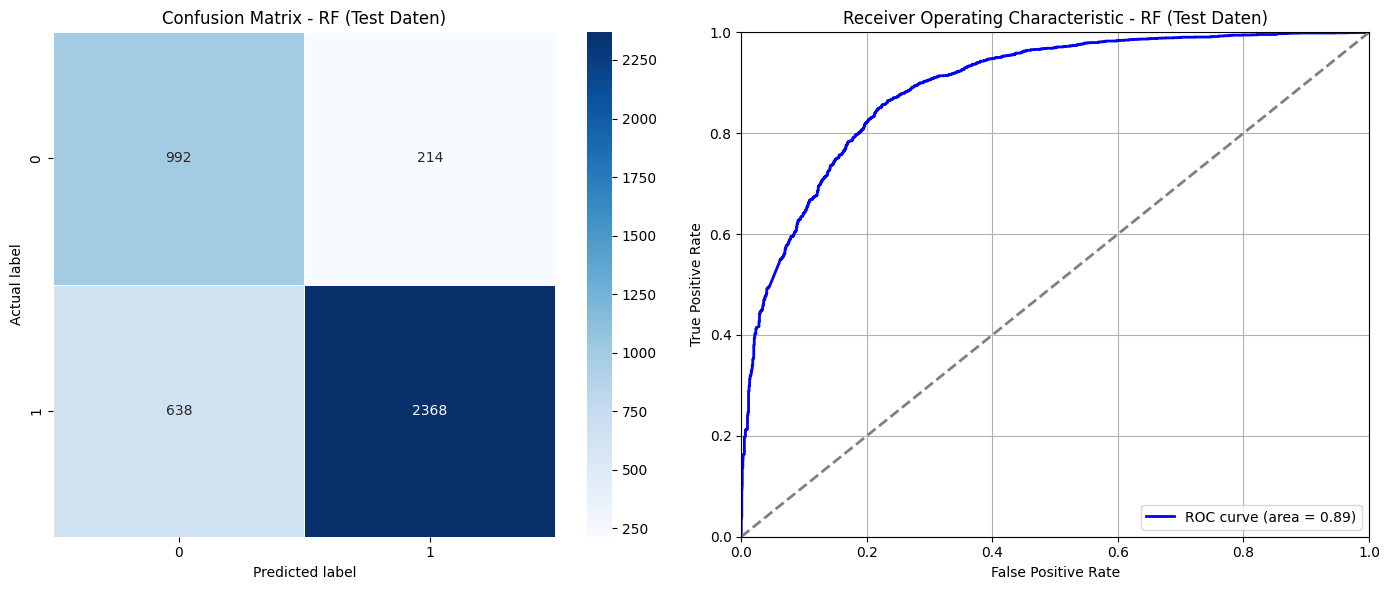

Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.61      0.82      0.70      1206
           1       0.92      0.79      0.85      3006

    accuracy                           0.80      4212
   macro avg       0.76      0.81      0.77      4212
weighted avg       0.83      0.80      0.81      4212



In [37]:
# Das beste Modell laden (Random Forest)
best_rf_model = joblib.load('best_random forest_tfidf_model.joblib')

# Testdaten vorhersagen
rf_predictions = best_rf_model.predict(X_test)
rf_probabilities = best_rf_model.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeiten für die positive Klasse

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_predictions)

# ROC-Kurve und AUC
fpr, tpr, _ = roc_curve(y_test, rf_probabilities)
roc_auc = auc(fpr, tpr)

# Subplots für Confusion Matrix und ROC-Kurve
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix plot
sns.heatmap(cm_rf, annot=True, fmt="d", linewidths=.5, cmap="Blues", ax=ax[0])
ax[0].set_title('Confusion Matrix - RF (Test Daten)')
ax[0].set_ylabel('Actual label')
ax[0].set_xlabel('Predicted label')

# ROC-Kurven Plot
ax[1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic - RF (Test Daten)')
ax[1].legend(loc="lower right")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Klassifikationsreport
print("Classification Report - Random Forest")
print(classification_report(y_test, rf_predictions))

### Diskussion über die Modellleistung

#### Analyse der Confusion Matrix, ROC-Kurve und des Klassifikationsberichts

**Confusion Matrix**  
Die Confusion Matrix zeigt, dass das Random Forest-Modell bei der Klassifikation von Testdaten solide Ergebnisse liefert. Von 4212 Vorhersagen waren 992 richtige Zuordnungen zur Klasse 0 (True Negatives) und 2368 richtige Zuordnungen zur Klasse 1 (True Positives). Es gab 214 False Positives und 638 False Negatives. Die Balance zwischen korrekt und falsch klassifizierten Werten verdeutlicht, dass das Modell Stärken in der Identifizierung der positiven Klasse (1) zeigt, jedoch Verbesserungspotenzial bei der Erkennung der negativen Klasse 0 besteht.

**ROC-Kurve**  
Die ROC-Kurve mit einer AUC von 0.89 zeigt, dass das Modell über eine gute Fähigkeit verfügt, zwischen den Klassen zu unterscheiden. Eine hohe AUC deutet auf ein gut generalisierbares Modell hin, welches in der Lage ist, die Klassen mit einer akzeptablen Präzision und Recall zu differenzieren.

**Klassifikationsbericht**  
Der Klassifikationsbericht zeigt, dass das Modell eine hohe Präzision (0.92) und einen hohen Recall (0.79) für die Klasse 1 aufweist. Dies zeigt die Fähigkeit des Modells, die Mehrheit der positiven Fälle korrekt zu erkennen, jedoch auf Kosten von falsch-negativen Vorhersagen. Die Werte für Klasse 0 (Precision: 0.61, Recall: 0.82) deuten auf eine etwas geringere, jedoch trotzdem solide Präzision bei der Erkennung dieser Klasse hin.

| **Modellleistung** |
|--------------------|
| **Klasse 0 (negative Reviews)**: Das Modell zeigt moderate Präzision, jedoch hohe Recall-Werte. Dies weist darauf hin, dass es gut darin ist, tatsächliche negative Fälle zu identifizieren, jedoch gelegentlich fälschlicherweise positive Fälle als negativ klassifiziert. |
| **Klasse 1 (positive Reviews)**: Hohe Präzision und ein guter Recall. Das Modell erkennt die Mehrheit der positiven Fälle korrekt und zeigt nur eine moderate Anzahl von Fehlklassifikationen. |

#### Wichtige Erkenntnisse
- **Klasse 0**: Trotz einer geringeren Präzision bleibt der Recall hoch, was bedeutet, dass viele negative Fälle korrekt erkannt werden. Verbesserungen der Präzision wären dennoch sehenswert, um falsch-positive Klassifikationen zu reduzieren.
- **Klasse 1**: Hohe Präzision und Recall zeigen, dass das Modell gut auf diese Klasse generalisiert und somit eine effektive Unterscheidung der positiven Fälle ermöglicht.

<h5 style="color: orange; font-weight: bold;">Conclusions and Future Work</h5>

### Zusammenfassung und Interpretation der erzielten Ergebnisse
In diesem Projekt wurde das Ziel verfolgt, ein Modell zur Klassifizierung von Steam-Bewertungen für das Spiel `Stranded Deep` zu entwickeln, um die Unterscheidung zwischen positiven und negativen Reviews zu ermöglichen. Dies wurde durch die Anwendung von Naive Bayes, Logistic Regression und Random Forest erreicht. Random Forest erwies sich als das leistungsstärkste Modell und zeigte insbesondere eine hohe Fähigkeit, positive Fälle korrekt zu identifizieren, während Logistic Regression ebenfalls robuste Ergebnisse lieferte. Die Analyse der Ergebnisse belegt die Effizienz dieser Algorithmen im Vergleich zur Baseline, die nur eine Vorhersage basierend auf der häufigsten Klasse darstellt.

### Kritische Reflexion und Bewertung der Anwendbarkeit der angewandten Methodik
Die gewählte Methodik, die von einer umfassenden Datenbereinigung, einer ausgewogenen Zielverteilung durch Downsampling und einer gründlichen Evaluation der Modelle mittels verschachtelter Kreuzvalidierung geprägt war, war für die Aufgabenstellung geeignet. Das gewählte Downsampling sorgte für eine balancierte Zielverteilung und verhinderte eine Verzerrung zugunsten der positiven Bewertungen. Der Einsatz verschiedener Modelle und Vektorisierungsstrategien verdeutlichte, dass Random Forest mit TFIDF-Vektorisierung die besten Ergebnisse lieferte, was die Fähigkeit zur Erfassung komplexer Textmuster widerspiegelt. Die Methodik hätte durch die Integration weiterer Feature-Engineering-Schritte oder die Untersuchung zusätzlicher Merkmale verbessert werden können.

### Generierter Wert im Kontext der Aufgabenstellung
Das entwickelte Modell liefert signifikanten Mehrwert, da es dem Unternehmen `Beam Team Publishing` die Möglichkeit bietet, negative Reviews frühzeitig zu erkennen und gezielt auf Kritikpunkte einzugehen. Durch die Analyse negativer Rückmeldungen kann das Unternehmen seine Gesamtbewertung auf Steam verbessern, wodurch potenzielle Kunden wieder stärker angesprochen und die Verkaufszahlen gesteigert werden können. Das Modell lässt sich zudem auf anderen Plattformen einsetzen, um den Austausch mit Spielern effizienter zu gestalten.

### Einschränkungen und Verbesserungsvorschläge
**Klassenungleichgewicht:** Das ursprüngliche Ungleichgewicht wurde durch Downsampling behandelt. Alternativ könnten fortschrittlichere Techniken wie SMOTE getestet werden, um Datenverzerrungen zu minimieren und das Training robuster zu machen.  
**Feature-Engineering:** Die Untersuchung weiterer textbasierter Merkmale, etwa durch Sentiment-Analyse, könnte zusätzliche Einblicke liefern. Das `Hours Played`-Feature zeigte nur eine schwache Korrelation und wurde aus der Klassifikation ausgeschlossen, könnte jedoch durch Verknüpfung mit anderen Features potenziell informativer werden.  
**Modellauswahl:** Boosting-Algorithmen wie XGBoost könnten zur Verbesserung der Leistung getestet werden, insbesondere bei komplexeren Textinteraktionen.